# Projekt: Autoencoder + Klasteryzacja + Inpainting

Szybki start
1. Bez Comet ML**: Po prostu uruchom wszystkie komórki - logowanie tylko do konsoli
2. Z Comet ML**: Ustaw `USE_COMET = True` w komórce konfiguracji i dodaj swój API key

#### Importy

In [1]:
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import numpy as np
import os

#### Importy z lokalnych plików

In [2]:
from src.models import ConvAutoencoder
from src.data import MaskedDataset, random_mask, sample_dataset, QuickTestDataset
from src.utils import train_autoencoder, extract_latent_vectors, cluster_and_visualize, visualize_reconstructions, LocalLogger

#### Konfiguracja logowania (Comet ML - opcjonalne)

Możesz wyłączyć Comet ML ustawiając `USE_COMET = False`

In [3]:
USE_COMET = False  # Zmień na True jeśli chcesz używać Comet ML
USE_LOCAL_LOGGER = True  # Lokalny logger jako alternatywa

if USE_COMET:
    try:
        experiment = Experiment(
            api_key="TWOJ_API_KEY_TUTAJ",  # ← wklej swój klucz
            project_name="inpainting-autoencoder",
            workspace="twoj_login_comet"    # np. 'lukasz_piotrek'
        )
        print("✅ Comet ML skonfigurowane")
    except Exception as e:
        print(f"❌ Błąd konfiguracji Comet ML: {e}")
        print("🔄 Przełączam na lokalny logger...")
        USE_COMET = False
        USE_LOCAL_LOGGER = True

if not USE_COMET:
    if USE_LOCAL_LOGGER:
        experiment = LocalLogger("autoencoder_inpainting")
        print("📁 Lokalny logger aktywny")
    else:
        experiment = None
        print("📝 Brak logowania - tylko konsola")

📁 Lokalne logowanie w: local_logs\autoencoder_inpainting_20251010_222819
📁 Lokalny logger aktywny


#### Przygotowanie danych

Możesz wybrat różne rozmiary datasetu:
- `DATASET_SIZE = 'full'` - pełny dataset
- `DATASET_SIZE = 'test'` - 100 próbek do szybkich testów  
- `DATASET_SIZE = 1000` - konkretna liczba próbek

In [4]:
DATASET_SIZE = 'test'  # 'full', 'test', lub liczba (np. 1000)
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

print("📦 Pobieranie CIFAR10...")
full_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

if DATASET_SIZE == 'full':
    train_data = full_dataset
    print(f"📊 Używam pełnego datasetu: {len(train_data)} próbek")
elif DATASET_SIZE == 'test':
    train_data = QuickTestDataset(full_dataset, size=100)
elif isinstance(DATASET_SIZE, int):
    train_data = sample_dataset(full_dataset, DATASET_SIZE, method='random')
else:
    raise ValueError(f"Nieznany DATASET_SIZE: {DATASET_SIZE}")

masked_data = MaskedDataset(train_data)
train_loader = DataLoader(masked_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"✅ Dataset gotowy: {len(train_data)} próbek, batch size: {BATCH_SIZE}")
print(f"🔄 Liczba batchy: {len(train_loader)}")

📦 Pobieranie CIFAR10...
⚡ Quick test dataset: 100 próbek dla szybkich testów
✅ Dataset gotowy: 100 próbek, batch size: 32
🔄 Liczba batchy: 4
⚡ Quick test dataset: 100 próbek dla szybkich testów
✅ Dataset gotowy: 100 próbek, batch size: 32
🔄 Liczba batchy: 4


#### Przykłady konfiguracji datasetu

Zmień `DATASET_SIZE` powyżej na:

```python
# Szybkie testy
DATASET_SIZE = 'test'        # 100 obrazów (kilka sekund)

# Małe eksperymenty  
DATASET_SIZE = 500           # 500 obrazów (1-2 minuty)
DATASET_SIZE = 1000          # 1000 obrazów (3-5 minut)

# Większe eksperymenty
DATASET_SIZE = 5000          # 5000 obrazów (10-15 minut)
DATASET_SIZE = 0.1           # 10% datasetu (~5000 obrazów)

# Pełny dataset (długo!)
DATASET_SIZE = 'full'        # Wszystkie 50,000 obrazów
```

#### Podgląd danych (opcjonalnie)

In [5]:
# Podgląd przykładowych danych (odkomentuj żeby zobaczyć)
# plt.figure(figsize=(12, 4))
# for i in range(6):
#     masked_img, original_img = masked_data[i]
    
#     plt.subplot(2, 6, i + 1)
#     plt.imshow(original_img.permute(1, 2, 0))
#     plt.title(f'Oryginalny {i+1}')
#     plt.axis('off')
    
#     plt.subplot(2, 6, i + 7)
#     plt.imshow(masked_img.permute(1, 2, 0))
#     plt.title(f'Z maską {i+1}')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# print(f"💡 Odkomentuj kod powyżej żeby zobaczyć przykładowe obrazy")

#### Konfiguracja modelu i trenowanie

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder(latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Używane urządzenie: {device}")
print(f"Liczba parametrów modelu: {sum(p.numel() for p in model.parameters()):,}")

Używane urządzenie: cpu
Liczba parametrów modelu: 34,017,347


#### Parametry eksperymentu

In [7]:
params = {
    "epochs": 5 if DATASET_SIZE == 'test' else 10,  # Mniej epok dla testów
    "batch_size": BATCH_SIZE,
    "learning_rate": 1e-3,
    "latent_dim": 128,
    "dataset": "CIFAR10",
    "dataset_size": len(train_data),
    "device": str(device)
}

# Logowanie parametrów
if USE_COMET and experiment:
    experiment.log_parameters(params)
    print("📊 Parametry zalogowane do Comet ML")
elif experiment:  # LocalLogger
    experiment.log_parameters(params)
else:
    print("📋 Parametry eksperymentu:")
    for key, value in params.items():
        print(f"  {key}: {value}")

📋 Parametry zapisane lokalnie:
  epochs: 5
  batch_size: 32
  learning_rate: 0.001
  latent_dim: 128
  dataset: CIFAR10
  dataset_size: 100
  device: cpu


#### Trenowanie modelu

In [8]:
losses = train_autoencoder(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=params["epochs"],
    experiment=experiment if USE_COMET else None,
    verbose=True
)

print(f"\n📈 Trenowanie zakończone!")
print(f"📉 Finalna strata: {losses[-1]:.4f}")
print(f"📊 Najniższa strata: {min(losses):.4f}")

🚀 Rozpoczynam trenowanie na 5 epok(ach)
📱 Urządzenie: cpu
📊 Rozmiar batcha: 32
🔄 Liczba batchy: 4
--------------------------------------------------
📈 Epoka [1/5] - Loss: 0.0832, Czas: 1.5s
📈 Epoka [1/5] - Loss: 0.0832, Czas: 1.5s
📈 Epoka [2/5] - Loss: 0.0665, Czas: 1.4s
📈 Epoka [2/5] - Loss: 0.0665, Czas: 1.4s
📈 Epoka [3/5] - Loss: 0.0598, Czas: 1.4s
📈 Epoka [3/5] - Loss: 0.0598, Czas: 1.4s
📈 Epoka [4/5] - Loss: 0.0590, Czas: 1.5s
📈 Epoka [4/5] - Loss: 0.0590, Czas: 1.5s
📈 Epoka [5/5] - Loss: 0.0562, Czas: 1.4s
--------------------------------------------------
✅ Trenowanie zakończone!
⏱️  Całkowity czas: 7.3s
📉 Finalna strata: 0.0562
📊 Najniższa strata: 0.0562 (epoka 5)

📈 Trenowanie zakończone!
📉 Finalna strata: 0.0562
📊 Najniższa strata: 0.0562
📈 Epoka [5/5] - Loss: 0.0562, Czas: 1.4s
--------------------------------------------------
✅ Trenowanie zakończone!
⏱️  Całkowity czas: 7.3s
📉 Finalna strata: 0.0562
📊 Najniższa strata: 0.0562 (epoka 5)

📈 Trenowanie zakończone!
📉 Finalna s

#### Wizualizacja rekonstrukcji (przykładowych)

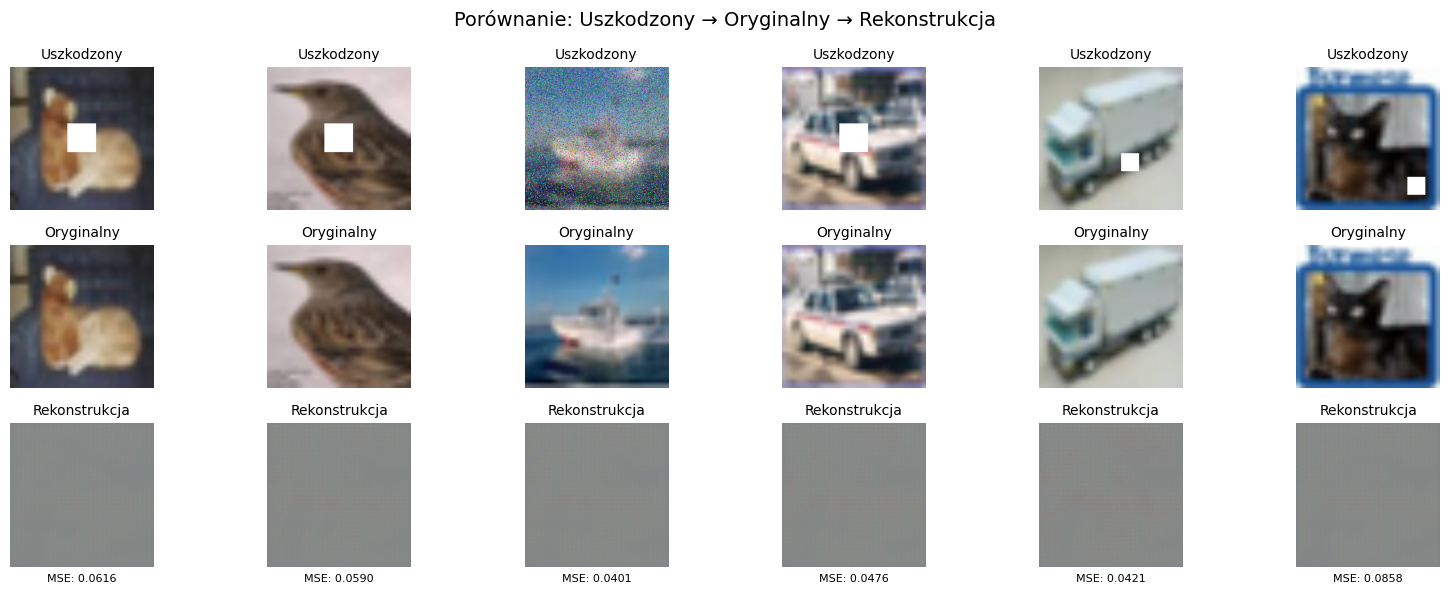

In [9]:
visualize_reconstructions(model, train_loader, device, n_samples=6)

#### Klasteryzacja przestrzeni latentnej

**Szacowany czas wykonania:**
- 100 próbek: ~10 sekund
- 1000 próbek: ~30 sekund  
- 5000 próbek: ~2 minuty

In [10]:
# Ekstraktowanie wektorów latentnych
# Automatycznie dostosuj max_samples do rozmiaru datasetu
if len(train_data) <= 200:
    max_samples = len(train_data)  # Użyj wszystkich dla małych datasetów
elif len(train_data) <= 1000:
    max_samples = min(500, len(train_data))  # Max 500 dla średnich
else:
    max_samples = 2000  # Max 2000 dla dużych

latent_vectors = extract_latent_vectors(
    model=model,
    dataloader=DataLoader(train_data, batch_size=64),
    device=device,
    max_samples=max_samples
)

print(f"✅ Wyekstraktowano {latent_vectors.shape[0]} wektorów latentnych")
print(f"📊 Rozmiar wektora: {latent_vectors.shape[1]}")

🔍 Ekstraktowanie wektorów latentnych...
✅ Wyekstraktowano 100 wektorów latentnych o wymiarze 128
✅ Wyekstraktowano 100 wektorów latentnych
📊 Rozmiar wektora: 128
✅ Wyekstraktowano 100 wektorów latentnych o wymiarze 128
✅ Wyekstraktowano 100 wektorów latentnych
📊 Rozmiar wektora: 128


#### Klasteryzacja i wizualizacja

🧠 Klasteryzacja KMEANS na 10 klastrów...
📊 Znaleziono 10 klastrów
📈 Silhouette score: 0.3345
📉 Redukcja wymiarowości metodą UMAP do 2D...
📊 Znaleziono 10 klastrów
📈 Silhouette score: 0.3345
📉 Redukcja wymiarowości metodą UMAP do 2D...


c:\Users\Filip\Documents\studia-local\Unsupervised-learning---images\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Zredukowano z 128D do 2D


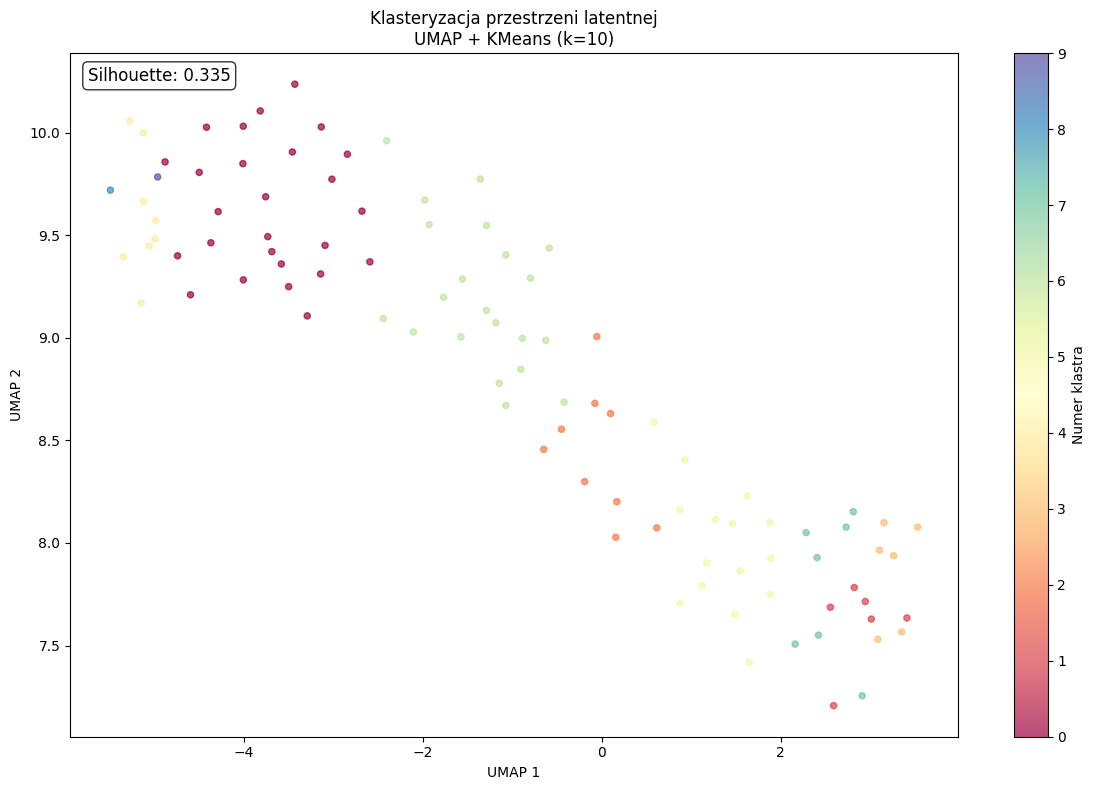


📊 Analiza klastrów:
  Klaster 0: 26 próbek (26.0%)
  Klaster 1: 6 próbek (6.0%)
  Klaster 2: 9 próbek (9.0%)
  Klaster 3: 6 próbek (6.0%)
  Klaster 4: 8 próbek (8.0%)
  Klaster 5: 15 próbek (15.0%)
  Klaster 6: 21 próbek (21.0%)
  Klaster 7: 7 próbek (7.0%)
  Klaster 8: 1 próbek (1.0%)
  Klaster 9: 1 próbek (1.0%)

🧠 Analiza klastrów zakończona!
📊 Silhouette score: 0.3345


In [11]:
kmeans, embedding, metrics = cluster_and_visualize(
    latent_vectors=latent_vectors,
    n_clusters=10,
    n_samples_viz=2000,
    experiment=experiment if USE_COMET else None
)

print(f"\n🧠 Analiza klastrów zakończona!")
if 'silhouette_score' in metrics:
    print(f"📊 Silhouette score: {metrics['silhouette_score']:.4f}")

#### Zapis modelu i zakończenie

In [12]:
model_path = "autoencoder.pth"
torch.save(model.state_dict(), model_path)
print(f"💾 Model zapisany: {model_path}")

# Zakończenie logowania
if experiment:
    if USE_COMET:
        experiment.log_model("autoencoder", model_path)
        print("📊 Model zalogowany do Comet ML")
    
    experiment.end()
    
    if USE_LOCAL_LOGGER and not USE_COMET:
        print("📁 Wszystkie wyniki zapisane lokalnie w folderze 'local_logs'")
else:
    print("📋 Eksperyment zakończony bez logowania")

print("✅ Wszystko gotowe!")

💾 Model zapisany: autoencoder.pth
📊 Podsumowanie zapisane: local_logs\autoencoder_inpainting_20251010_222819\summary.json
📈 Brak metryk do wykreślenia

🎯 Eksperyment zakończony!
📁 Wszystkie pliki w: local_logs\autoencoder_inpainting_20251010_222819
📊 Zalogowane metryki: []
📁 Wszystkie wyniki zapisane lokalnie w folderze 'local_logs'
✅ Wszystko gotowe!


#### Przykłady dalszego użycia

##### Szybkie eksperymenty:
```python
# 1. Zmień rozmiar datasetu na początku:
DATASET_SIZE = 'test'    # 100 próbek - szybkie testy
DATASET_SIZE = 1000      # 1000 próbek - eksperymenty

# 2. Testuj różne typy uszkodzeń:
from src.data import rectangular_mask, noise_mask
masked_data = MaskedDataset(train_data, damage_functions=[noise_mask])

# 3. Załaduj zapisany model:
model.load_state_dict(torch.load("autoencoder.pth"))
```

##### Zaawansowane eksperymenty:
- Dodaj własne funkcje uszkodzeń w `src.data.damages`
- Eksperymentuj z architekturą w `src.models.autoencoder`
- Stwórz nowe wizualizacje w `src.utils.visualization`
- Przetestuj inne algorytmy klasteryzacji w `src.utils.analysis`